In [12]:
import os
import random
import sys
import time

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch
# from datasets import getPairedDataset
from model import DecoderA, DecoderB, EncoderA, EncoderB
from plotting_utils import *
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, SVHN
from util import apply_poe, unpack_data

sys.path.append("../")
import pickle

import probtorch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
sim_name = "random_18.9k"
train = pickle.load(
    open(
        os.path.join("..", "..", "data", "lgn-v1", sim_name, f"{sim_name}_train.pkl"),
        "rb",
    )
)

X = torch.Tensor(train["responses"]["lgn"]).to(device)
Y = torch.Tensor(train["responses"]["v1"]).to(device)

test = pickle.load(
    open(
        os.path.join("..", "..", "data", "lgn-v1", sim_name, f"{sim_name}_test.pkl"),
        "rb",
    )
)

xpos_test = test["stim_params"]["x"]
ypos_test = test["stim_params"]["y"]
lgn_p_test = test["stim_params"]["lgn_p"]
v1_p_test = test["stim_params"]["v1_p"]

X_test = torch.Tensor(test["responses"]["lgn"]).to(device)
Y_test = torch.Tensor(test["responses"]["v1"]).to(device)


In [10]:
n_shared = 2
n_privateA = 1
n_privateB = 1
wseed = 0

encA = EncoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
decA = DecoderA(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateA).to(device)
encB = EncoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)
decB = DecoderB(wseed, zShared_dim=n_shared, zPrivate_dim=n_privateB).to(device)

decA.load_state_dict(torch.load("../weights/lgn-v1/lgn-v1_6x200_3000epoch_lambda100-decA.rar"))
encA.load_state_dict(torch.load("../weights/lgn-v1/lgn-v1_6x200_3000epoch_lambda100-encA.rar"))
encB.load_state_dict(torch.load("../weights/lgn-v1/lgn-v1_6x200_3000epoch_lambda100-encB.rar"))
decB.load_state_dict(torch.load("../weights/lgn-v1/lgn-v1_6x200_3000epoch_lambda100-decB.rar"))

q = encA(X_test, num_samples=1) 
q = encB(Y_test, num_samples=1, q=q)    

mu_poe, std_poe = apply_poe(
                True,
                q["sharedA"].dist.loc,
                q["sharedA"].dist.scale,
                q["sharedB"].dist.loc,
                q["sharedB"].dist.scale,
            )
q.normal(mu_poe, std_poe, name="poe")


rec_a = decA.forward2(torch.cat((q["privateA"].dist.loc , q["poe"].dist.loc), dim=-1)).squeeze(0).detach().cpu().numpy().reshape(-1,20,20)
rec_b = decB.forward2(torch.cat((q["privateB"].dist.loc , q["poe"].dist.loc), dim=-1)).squeeze(0).detach().cpu().numpy().reshape(-1,40,20)

z_a = q["privateA"].dist.loc.squeeze(0).detach().cpu().numpy()
z_b = q["privateB"].dist.loc.squeeze(0).detach().cpu().numpy()
z_shared = q["poe"].dist.loc.squeeze(0).detach().cpu().numpy()


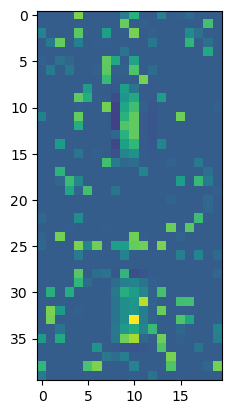

In [82]:
plt.imshow(Y_test[0].detach().cpu().numpy().reshape(40,20), vmin=-.5, vmax=1.2);

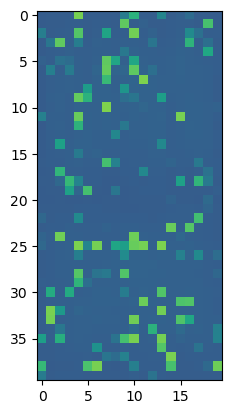

In [83]:
plt.imshow(rec_b[0], vmin=-.5, vmax=1.2); 

In [84]:
rec_a.shape

(3780, 20, 20)

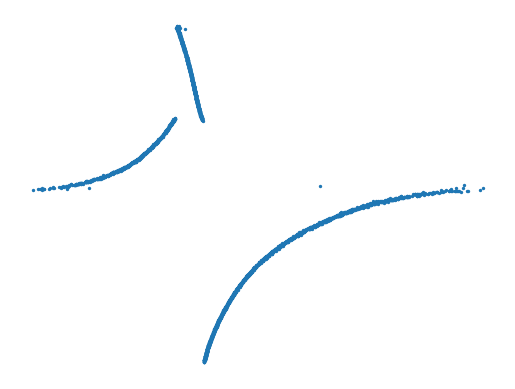

In [27]:
plt.scatter(z_a, test["stim_params"]["lgn_p"], s=2)
plt.axis('off')
plt.savefig("../../figures/DMVAE_lgn-v1_z-a.png", transparent=True, dpi=300)

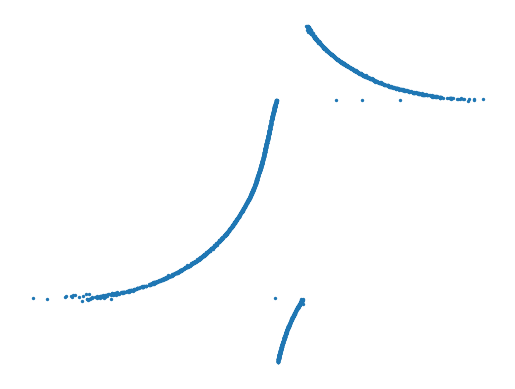

In [28]:
plt.scatter(z_b, test["stim_params"]["v1_p"], s=2)
plt.axis('off')
plt.savefig("../../figures/DMVAE_lgn-v1_z-b.png", transparent=True, dpi=300)

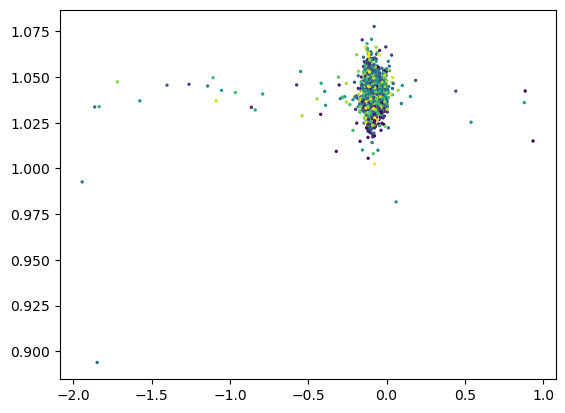

In [6]:
plt.scatter(z_shared[:,0], z_shared[:,1], c=test["stim_params"]["x"],s=2)
plt.savefig("../../figures/DMVAE_lgn-v1_shared_supp.svg", transparent=True, dpi=300)

In [ ]:
plt.savefig("../../figures/DMVAE_lgn-v1_z-a.svg", transparent=True, dpi=300)

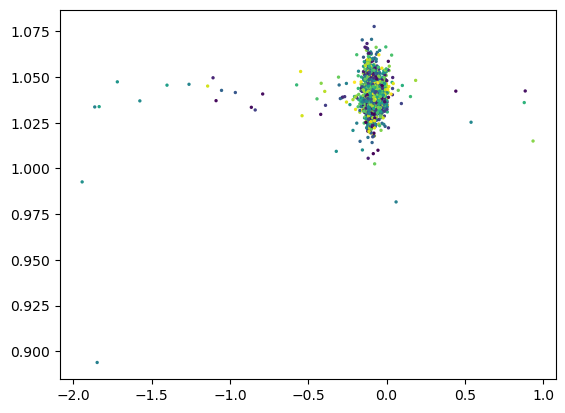

In [14]:
plt.scatter(z_shared[:,0], z_shared[:,1], c=test["stim_params"]["y"],s=2)

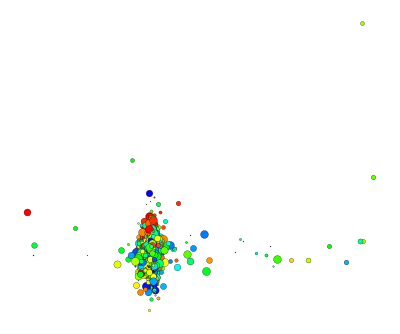

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# colors for x and y positions, normalized to [0,1]
xcolrange = (xpos_test - xpos_test.min())/(xpos_test.max() - xpos_test.min())
ycolrange = (ypos_test - ypos_test.min())/(ypos_test.max() - ypos_test.min())

maxMarkerSize = 6
minMarkerSize = 0.5

# --------------------------------------------------------
#
#  Main plot
#
# --------------------------------------------------------

plt.figure(figsize=(12,10))
plt.subplot(2, 2, 1)    
for i in range(z_shared.shape[0]):
    # Each point gets a color based on its x position
    red_blue = mcolors.to_rgb(mcolors.hsv_to_rgb([0.666 * xcolrange[i], 1.0, 1.0]))
    # Each point gets a size based on its y position
    plt.plot(-z_shared[i,0], -z_shared[i,1], 'o', color=red_blue, 
             markersize=ycolrange[i]*(maxMarkerSize-minMarkerSize)+minMarkerSize, 
             markeredgecolor='black', markeredgewidth=0.2)
# plt.title("LGN shared")
plt.xticks([]); plt.yticks([])
axisWidthChange(0.9, 'l')
axisHeightChange(0.9, 't')
plt.gca().set_frame_on(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)


# ----- add arrows to the axes -- not quite yet working -----
# from matplotlib.patches import FancyArrowPatch

# arrowprops=dict(arrowstyle="<|-", color="k", lw=1)
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
# # Adding arrowheads: x-axis and y-axis (start point, end point, arrow properties):
# plt.gca().add_patch(FancyArrowPatch((xlim[0], ylim[0]), (xlim[1], ylim[0]), **arrowprops))  # x-axis arrow
# plt.gca().add_patch(FancyArrowPatch((xlim[0], ylim[0]), (xlim[0], ylim[1]), **arrowprops))  # y-axis arrow
# # Adjust the axis limits to make sure arrows are fully visible
# plt.xlim(-49, 5)
# plt.ylim(-18, 1)
# ---- end add arrows ----

# --------------------------------------------------------
#
#  plot making legend for dot size and color
#
# --------------------------------------------------------
# ax2 = plt.axes(position=plt.gca().get_position())
# axisWidthChange(0.15, 'r')
# axisMove(0.06, 0)
# plt.xticks([]); plt.yticks([])
# numItems = 12  # number of vertical color and dot size entries
# for i in range(numItems):
#     # First the colored dots
#     red_blue = mcolors.to_rgb(mcolors.hsv_to_rgb([0.666 * i/(numItems-1), 1.0, 1.0]))
#     plt.plot(0, i/(numItems-1), 'o', color=red_blue, 
#              markersize=maxMarkerSize+3, 
#              markeredgecolor='black', markeredgewidth=0.2)
#     # Then the different sized dots
#     plt.plot(1.2, i/(numItems-1), 'o', color='w',
#              markersize=(i/11)*(maxMarkerSize-minMarkerSize)+minMarkerSize+3, 
#              markeredgecolor='black', markeredgewidth=1)
#     plt.xlim(-0.5,2)
# plt.gca().set_frame_on(False)
# plt.yticks(np.arange(0,1.1,0.1));
# plt.gca().set_yticklabels(np.round(np.arange(0,1.1,0.1), 2), fontsize=15)
# ax2.tick_params(axis='y', labelright=True, labelleft=False, left=False, right=True)
# plt.text(-0.5, 1.05, "y pos", fontsize=15, rotation=70); # , transform=ax2.transAxes);
# plt.text( 0.8, 1.05, "x pos", fontsize=15, rotation=70); # , transform=ax2.transAxes);


# --------------------------------------------------------
#
#  save the plot
#
# --------------------------------------------------------
plt.savefig("../../Figures/DMVAE_shared_LGN.png", bbox_inches='tight', transparent=True, dpi=300)


In [22]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(z_a, test["stim_params"]["lgn_p"])
print("LGN private decoding from z_a R^2: %.4f" % reg.score(z_a, test["stim_params"]["lgn_p"]))

reg = LinearRegression().fit(z_b, test["stim_params"]["v1_p"])
print("V1 private decoding from z_b R^2: %.4f" % reg.score(z_b, test["stim_params"]["v1_p"]))

reg = LinearRegression().fit(z_shared, test["stim_params"]["x"])
print("X decoding from shared R^2: %.4f" % reg.score(z_shared, test["stim_params"]["x"]))

reg = LinearRegression().fit(z_shared, test["stim_params"]["y"])
print("Y decoding from shared R^2: %.4f" % reg.score(z_shared, test["stim_params"]["y"]))

LGN private decoding from z_a R^2: 0.0986
V1 private decoding from z_b R^2: 0.2697
X decoding from shared R^2: 0.0025
Y decoding from shared R^2: 0.0026
